# Evaluation and Results Analysis
As a first step, we print out and save classification reports for both Aspect Category Detection and Sentiment Polarity. Then, an outputfile is generated for a direct comparison between gold and prediction, together with a confusion matrix for both systems.

In [1]:
import torch
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader         
from sklearn.metrics import classification_report
import pandas as pd
from utils import plot_confusion_matrix, validation

In [2]:
# define parameters for validation
batch_size = 32

# Padd or truncate text sequences to a specific length
max_length = 124

# Aspect labels
labels_ids_a = { 'Service' : 0, 'Company' : 1, 'Staff' : 2, 'Price' : 3, 'Travel' : 4, 
          'Aircraft equipment' : 5, 'Food' : 6, 'Safety' : 7, 'Boarding' : 8, 
          'Luggage' : 9,'Information' : 10, 'Others' : 11, 'Multiple' : 12, 'NA' : 13
                }

# How many aspect labels are we using 
n_labels_a = len(labels_ids_a)

# Sentiment labels
labels_ids_s = { "Neutral": 0,
                 "Positive": 1,
                "Negative": 2,
                "Mix": 3
                }

# How many sentiment labels are we using .
n_labels_s = len(labels_ids_s)

In [3]:
# Define the PyTorch Dataset class
# this class deifinition was adopted and modified from the work of George Mihaila: 
# https://gmihaila.medium.com/fine-tune-transformers-in-pytorch-using-transformers-57b40450635 
class AirlineFeedbackDataset(Dataset):
    r"""PyTorch Dataset class for loading data.

    This is where the data parsing happens and where the text gets encoded using
    loaded tokenizer_a.

    This class is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed 
    straight into the model_a - `model_a(**batch)`.

    Arguments:

    path (:obj:`str`):
        Path to the data partition.

    use_tokenizer (:obj:`transformers.tokenization_?`):
        Transformer type tokenizer_a used to process raw text into numbers.

    labels_ids (:obj:`dict`):
        Dictionary to encode any labels names into numbers. Keys map to 
        labels names and Values map to number associated to those labels.

    max_sequence_len (:obj:`int`, `optional`)
        Value to indicate the maximum desired sequence to truncate or pad text
        sequences. If no value is passed it will used maximum sequence size
        supported by the tokenizer_a and model_a.

    """

    def __init__(self, path, use_tokenizer, labels_ids, max_sequence_len=None):
        
        df_train = pd.read_csv(path, delimiter=';', header= 0, dtype= str, keep_default_na=False, encoding= 'utf-8')
        df_train = df_train.dropna()
        # Check max sequence length.
        max_sequence_len = 64
        
        texts = []
        labels = []
        print('Reading partitions...')
        # we loop through each label.
        if labels_ids == labels_ids_a:
            [labels.append(labels_ids[label]) for label in df_train['Aspect_Category'].astype(str)] # put in one line without append
        else:
            [labels.append(labels_ids[label]) for label in df_train['Sentiment'].astype(str)]
        [texts.append(sentence) for sentence in df_train['Sentence'].astype(str)]   

        # Number of exmaples.
        self.n_examples = len(labels)
        # Use tokenizer_a on texts. This can take a while.
        print('Using tokenizer_a on all texts. This can take a while...')
        self.inputs = use_tokenizer(texts, add_special_tokens=True, truncation=True, padding=True, return_tensors='pt',  max_length=max_sequence_len)
        # Get maximum sequence length.
        self.sequence_len = self.inputs['input_ids'].shape[-1]
        print('Texts padded or truncated to %d length!' % self.sequence_len)
        # Add labels.
        self.inputs.update({'labels':torch.tensor(labels)})
        print('Finished!\n')

        return

    def __len__(self):
        r"""When used `len` return the number of examples.

        """

        return self.n_examples

    def __getitem__(self, item):
        r"""Given an index return an example from the position.

        Arguments:

          item (:obj:`int`):
              Index position to pick an example to return.

        Returns:
          :obj:`Dict[str, object]`: Dictionary of inputs that feed into the model_a.
          It holddes the statement `model_a(**Returned Dictionary)`.

        """

        return {key: self.inputs[key][item] for key in self.inputs.keys()}


### Aspect Category Detection  

In [4]:
# LOAD MODEL
tokenizer_a = torch.load("models/r_aspect_tokenizer_2e")
model_a = torch.load("models/r_aspect_model_2e")
device_a = torch.load("models/r_aspect_device_2e")


In [5]:
# Create pytorch dataset from the test set
test_dataset_a =  AirlineFeedbackDataset(path="path/to/test.csv", 
                               use_tokenizer=tokenizer_a, 
                               labels_ids=labels_ids_a,
                               max_sequence_len=max_length)

print('Created `test_dataset_a` with %d examples!'%len(test_dataset_a))

# Move pytorch dataset into dataloader.
test_dataloader_a = DataLoader(test_dataset_a, batch_size=batch_size, shuffle=False)
print('Created `test_dataloader` with %d batches!'%len(test_dataloader_a))
print()
print()
print('Loading Report...')
# Get prediction from model_a on validation data. This is where you should use
# your test data.
true_labels_a, predictions_labels_a, avg_epoch_loss = validation(model_a,test_dataloader_a, device_a)

# Create the evaluation report.
evaluation_report_a = classification_report(true_labels_a, predictions_labels_a,labels=list(labels_ids_a.values()), target_names=list(labels_ids_a.keys()))
# Show the evaluation report.
print('Aspect: ')
print(evaluation_report_a)


Reading partitions...
Using tokenizer_a on all texts. This can take a while...
Texts padded or truncated to 64 length!
Finished!

Created `test_dataset_a` with 249 examples!
Created `test_dataloader` with 8 batches!


Loading Report...



Aspect: 
                    precision    recall  f1-score   support

           Service       0.57      0.42      0.48        19
           Company       0.76      0.72      0.74        18
             Staff       0.86      0.97      0.91        31
             Price       0.00      0.00      0.00         5
            Travel       0.62      0.50      0.56        20
Aircraft equipment       0.72      0.88      0.79        26
              Food       0.75      0.90      0.82        10
            Safety       0.00      0.00      0.00         3
          Boarding       1.00      0.22      0.36         9
           Luggage       0.90      0.75      0.82        12
       Information       1.00      0.12      0.22         8
            Others       0.00      0.00      0.00         1
          Multiple       1.00      0.09      0.17        11
                NA       0.66      0.95      0.78        76

          accuracy                           0.71       249
         macro avg       0.6

C:\Users\gabriele\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [6]:
# SAVE CLASSIFICATION REPORT TO OUTPUT FILE
evaluation_report_a = classification_report(true_labels_a, predictions_labels_a, output_dict=True, labels=list(labels_ids_a.values()), target_names=list(labels_ids_a.keys()), digits=2)
clsf_report = pd.DataFrame(evaluation_report_a).transpose()
clsf_report.to_excel('Classification_Report_a.xlsx', index= True)


### Sentiment Polary classification

In [7]:
# repeat the previous operation 

tokenizer_s = torch.load("models/r_sentiment_tokenizer_2e")
model_s = torch.load("models/r_sentiment_model_2e")
device_s = torch.load("models/r_sentiment_device_2e")

In [8]:
# Create pytorch dataset from test set.
test_dataset_s =  AirlineFeedbackDataset(path="path/to/test.csv", 
                               use_tokenizer=tokenizer_s, 
                               labels_ids=labels_ids_s,
                               max_sequence_len=max_length)

print('Created `test_dataset_s` with %d examples!'%len(test_dataset_s))

test_dataloader_s = DataLoader(test_dataset_s, batch_size=batch_size, shuffle=False)
print('Created `test_dataloader` with %d batches!'%len(test_dataloader_s))
print()
print()
print('Loading Report...')
# Get prediction from model_s on validation data.
true_labels_s, predictions_labels_s, avg_epoch_loss = validation(model_s,test_dataloader_s, device_s)

# Create the evaluation report.
evaluation_report_s = classification_report(true_labels_s, predictions_labels_s, labels=list(labels_ids_s.values()), target_names=list(labels_ids_s.keys()), digits=2)
# Show the evaluation report.
print('Sentiment: ')
print(evaluation_report_s)


Reading partitions...
Using tokenizer_a on all texts. This can take a while...
Texts padded or truncated to 64 length!
Finished!

Created `test_dataset_s` with 249 examples!
Created `test_dataloader` with 8 batches!


Loading Report...



Sentiment: 
              precision    recall  f1-score   support

    Positive       0.79      0.92      0.85        37
    Negative       0.91      0.77      0.83       103
     Neutral       0.78      0.94      0.85        99
         Mix       0.00      0.00      0.00        10

    accuracy                           0.83       249
   macro avg       0.62      0.66      0.63       249
weighted avg       0.80      0.83      0.81       249



C:\Users\gabriele\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [9]:
# save the report
evaluation_report_s = classification_report(true_labels_s, predictions_labels_s, output_dict=True, labels=list(labels_ids_s.values()), target_names=list(labels_ids_s.keys()))
clsf_report = pd.DataFrame(evaluation_report_s).transpose()
clsf_report.to_excel('Classification_Report_s.xlsx', index= True)

## Results analysis
Generate an output file containing each test sentence with a comparison between human annotation and machine prediction. Finally, generate a confusion matrix for each system (ACD, SP).

In [10]:
# GENERATE OUTPUT WITH PREDICTION OF ASPECT AND SENTIMENT FOR EACH SENTENCE
# read the test file and store the feedbacks
validation_df = pd.read_csv("path/to/test.csv", delimiter=';', header= 0, dtype= str, keep_default_na=False, encoding= 'utf-8')
sentences = validation_df['Sentence']

In [11]:
# function to return the key for any value in the labels id dictionary
def get_key(labels_id_dict, val):
    """"
    function to return the key 
    for any value in a dictionary
    """"
    for key, value in labels_id_dict.items():
         if val == value:
            return key
 
    return "key doesn't exist"

In [12]:
# Save output to .txt file 
# the output is hidden because it shows private data
f = open("absa_output.txt", "w")
i = 1
for s, gold_a, pred_a, gold_s, pred_s in zip(sentences, true_labels_a, predictions_labels_a, true_labels_s, predictions_labels_s):
    print('SENTENCE', i, ':  ', s, file=f)
    print('GOLD ASPECT:    ', get_key(labels_ids_a, gold_a), '                      PREDICTION -->', get_key(labels_ids_a, pred_a), file=f)
    print('GOLD SENTIMENT: ', get_key(labels_ids_s, gold_s), '                      PREDICTION -->', get_key(labels_ids_s, pred_s), file=f)
    i += 1
    print('', file=f)
    print('________________________________________________________________________________________________________________________________________________', file=f)
f.close()

Example output: 

SENTENCE 1 :   Way above excellent service and we will remember that for all our future trips even when the kids are not going with us!

GOLD ASPECT:  Service    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; PREDICTION --> Service

GOLD SENTIMENT:  Positive    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; PREDICTION --> Positive

### Confusion Matrix

Confusion matrix


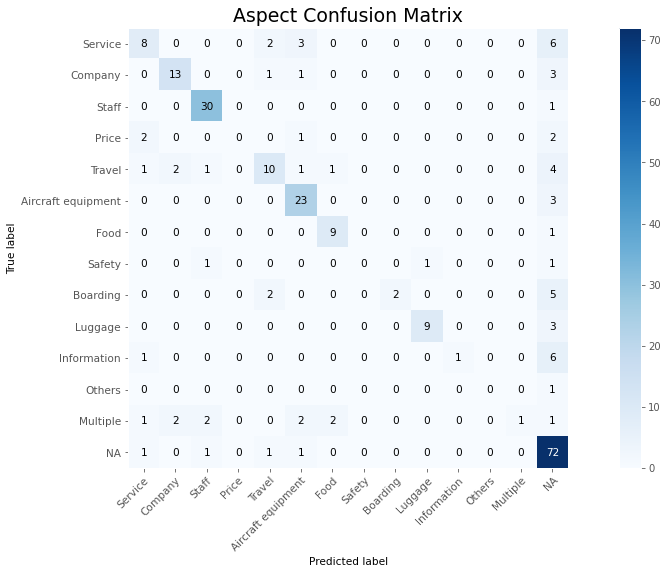

In [13]:
# Plot confusion matrix Aspect.
plot_confusion_matrix(y_true=true_labels_a, y_pred=predictions_labels_a, use_title='Aspect Confusion Matrix',
                      classes=list(labels_ids_a.keys()), normalize=False, width= 2, height= 2,
                      magnify=3,
                      );

Confusion matrix


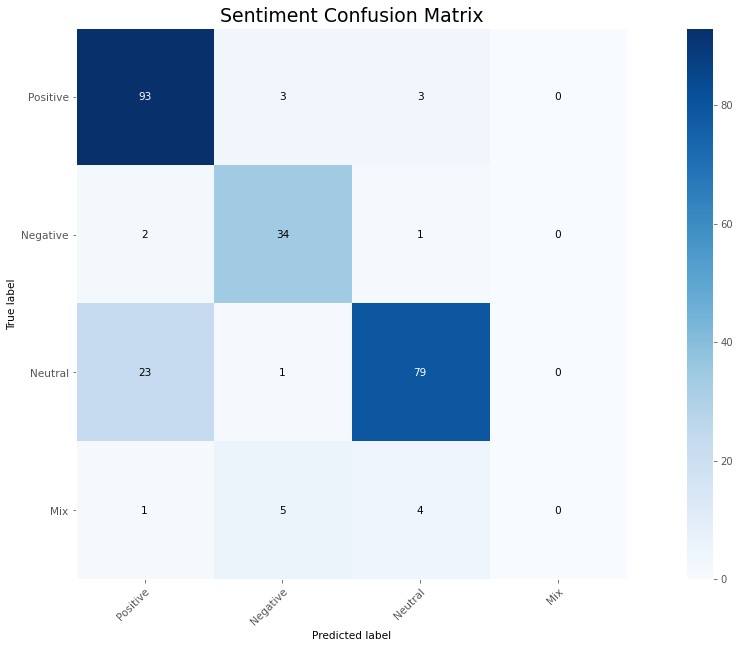

In [14]:
# Plot confusion matrix Sentiment.
plot_confusion_matrix(y_true=true_labels_s, y_pred=predictions_labels_s, use_title='Sentiment Confusion Matrix',
                      classes=list(labels_ids_s.keys()), normalize=False, width= 2, height= 2,
                      magnify=3,
                      );

## End of the notebook